# DADA2 re-run to check rarefaction curves for  Exp 1

* Need to define for each dataset
** Number of cores
** OutFolder
** Path to sequence directory

In [1]:
ncores = 20

In [2]:
library(dada2)
library(tidyr)
library(dplyr)

Loading required package: Rcpp
Warning message:
“package ‘Rcpp’ was built under R version 3.6.1”Warning message:
“multiple methods tables found for ‘lengths’”Warning message:
“multiple methods tables found for ‘rowSums’”Warning message:
“multiple methods tables found for ‘colSums’”Warning message:
“multiple methods tables found for ‘rowMeans’”Warning message:
“multiple methods tables found for ‘colMeans’”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [49]:
seqDIR = '~/Hyphosphere/data/MiSeq/Exp1/'
path = seqDIR

#location of taxonomy database
#TrainingSet = '~/databases/silva_nr_v132_train_set.fa.gz'
#SpeciesTraining = '~/databases/silva_species_assignment_v132.fa.gz'

# Sample data table
SamTab = '~/Hyphosphere/3exp_metadata_final.txt'

# output folder
OutFolder = '~/Hyphosphere/data/Exp1/DADA2Files/Pooled-rerun'


# Filter and trim


In [4]:
#Collect forward and reverse names in order
fastqFs <- sort(list.files(path, pattern=".R1_001.fastq"))
fastqRs <- sort(list.files(path, pattern=".R2_001.fastq"))
if(length(fastqFs) != length(fastqRs)) stop("Forward and reverse files do not match.")

In [ ]:
#sample.names

## Plot quality profiles of forward and reverse reads

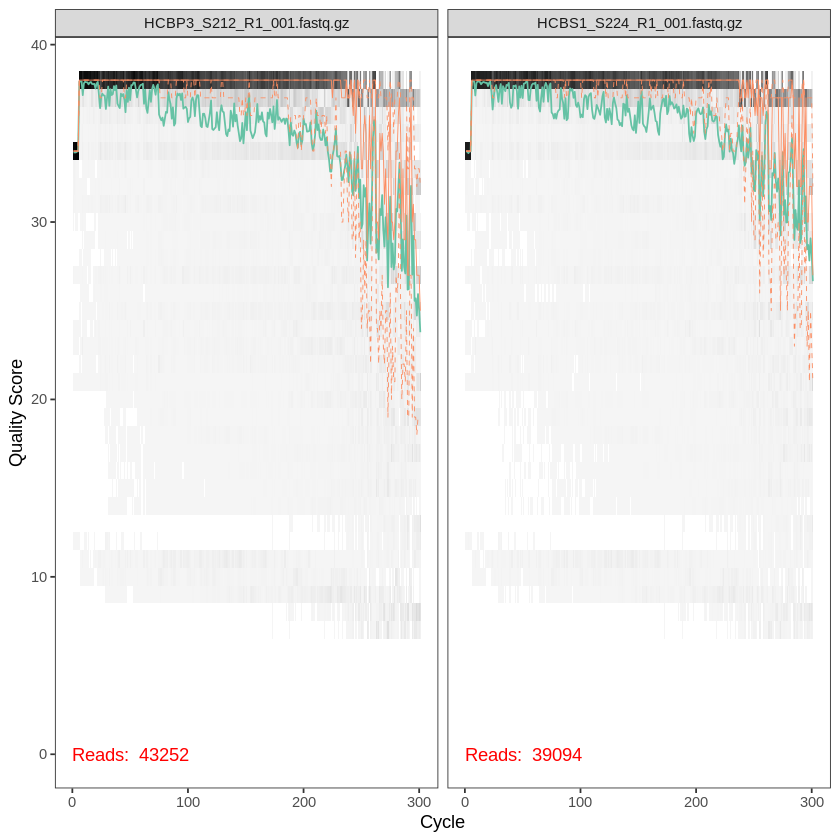

In [5]:
plotQualityProfile(file.path(path,fastqFs[17:18]))


* Foward reads look very good.  Truncate to 220

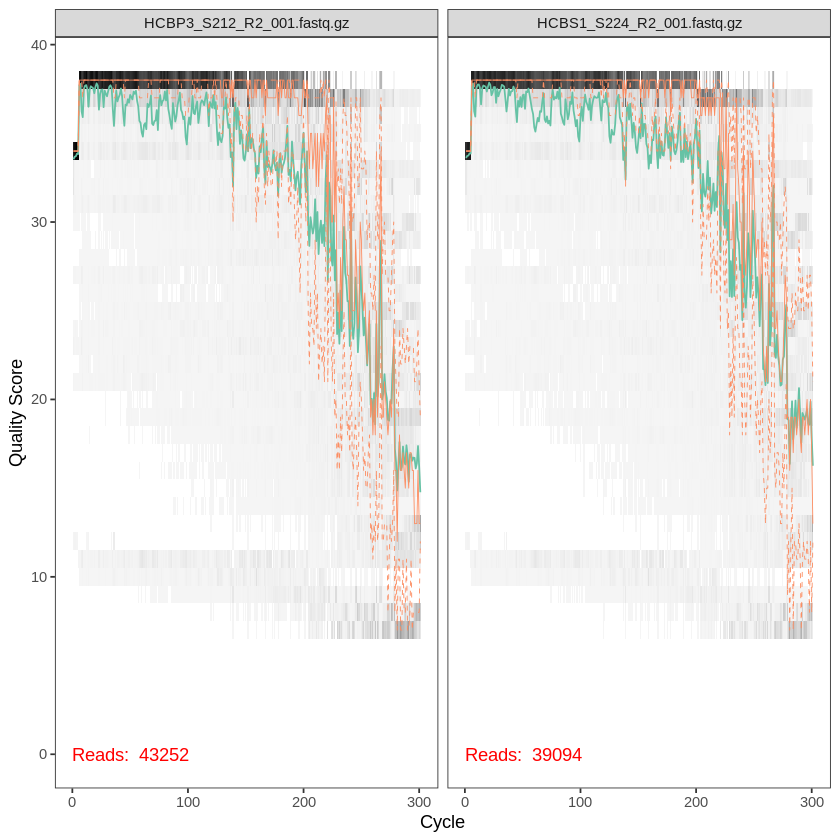

In [6]:
plotQualityProfile(file.path(path,fastqRs[17:18]))

# Perform filtering and trimming


In [8]:
filtpathF <- file.path(path, "filtered_F") # Filtered forward files go into the pathF/filtered/ subdirectory
filtpathR <- file.path(path, "filtered_R") # ...

* Note that primers remain on sequences from UMGC, so trimLeft(19,20) is included in this dataset

In [9]:
# Filtering: THESE PARAMETERS ARENT OPTIMAL FOR ALL DATASETS
out = filterAndTrim(fwd=file.path(path, fastqFs), filt=file.path(filtpathF, fastqFs),
              rev=file.path(path, fastqRs), filt.rev=file.path(filtpathR, fastqRs),
              truncLen=c(210,125), maxEE=2, truncQ=2, maxN=0, rm.phix=TRUE, trimLeft=c(19,20),
              compress=TRUE, verbose=TRUE, multithread=ncores)

Creating output directory: /home/be68/Hyphosphere/data/MiSeq/Exp1//filtered_F
Creating output directory:/home/be68/Hyphosphere/data/MiSeq/Exp1//filtered_R


In [10]:
head(out)

,reads.in,reads.out
10xBLS156_S303_R1_001.fastq.gz,76535,71931
2xBLS143_S297_R1_001.fastq.gz,46036,42761
5xBLS120_S300_R1_001.fastq.gz,58139,52793
BartHigh_S258_R1_001.fastq.gz,50441,46587
BartLow_S270_R1_001.fastq.gz,59500,56642
BaseA_S310_R1_001.fastq.gz,43371,40476


In [11]:
filtFs <- list.files(filtpathF, pattern=".fastq", full.names = TRUE)
filtRs <- list.files(filtpathR, pattern=".fastq", full.names = TRUE)
sample.names <- sapply(strsplit(basename(filtFs), "_R1_001.fastq"), `[`, 1) # Assumes filename = samplename_XXX.fastq.gz
sample.namesR <- sapply(strsplit(basename(filtRs), "_R2_001.fastq"), `[`, 1) # Assumes filename = samplename_XXX.fastq.gz
if(!identical(sample.names, sample.namesR)) stop("Forward and reverse files do not match.")
names(filtFs) <- sample.names
names(filtRs) <- sample.names
sample.names

[1] "10xBLS156_S303"        "2xBLS143_S297"         "5xBLS120_S300"        
 [4] "BartHigh_S258"         "BartLow_S270"          "BaseA_S310"           
 [7] "BaseB_S291"            "BaseC_S294"            "HCBF1_S247"           
[10] "HCBF2_S259"            "HCBF3_S271"            "HCBN1_S211"           
[13] "HCBN2_S223"            "HCBN3_S235"            "HCBP1_S283"           
[16] "HCBP2_S200"            "HCBP3_S212"            "HCBS1_S224"           
[19] "HCBS2_S236"            "HCBS3_S248"            "HCHF1_S250"           
[22] "HCHF2_S262"            "HCHF3_S274"            "HCHN1_S214"           
[25] "HCHN2_S226"            "HCHN3_S238"            "HCHP1_S286"           
[28] "HCHP2_S203"            "HCHP3_S215"            "HCHS1_S227"           
[31] "HCHS2_S239"            "HCHS3_S251"            "HCRF1_S201"           
[34] "HCRF2_S213"            "HCRF3_S225"            "HCRN1_S260"           
[37] "HCRN2_S272"            "HCRN3_S284"            "HCRP1_S237"           
[40] "HCRP2_S249"            "HCRP3_S261"            "HCRS1_S273"           
[43] "HCRS2_S285"            "HCRS3_S202"            "Hneg1_S263"           
[46] "NegativeH2O_S282"      "UMGC_H2O_001_A04_S4"   "UMGC_H2O_001_A06_S6"  
[49] "UMGC_H2O_002_B04_S112" "UMGC_H2O_002_B06_S114" "UMGC_H2O_003_A07_S199"
[52] "UMGC_H2O_003_G11_S275" "UMGC_H2O_004_F03_S306"

## Learn errors

In [12]:
set.seed(100)
# Learn forward error rates
errF <- learnErrors(filtFs, multithread=ncores)
# Learn reverse error rates
errR <- learnErrors(filtRs, multithread=ncores)

106239166 total bases in 556226 reads from 13 samples will be used for learning the error rates.
102272730 total bases in 974026 reads from 27 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”

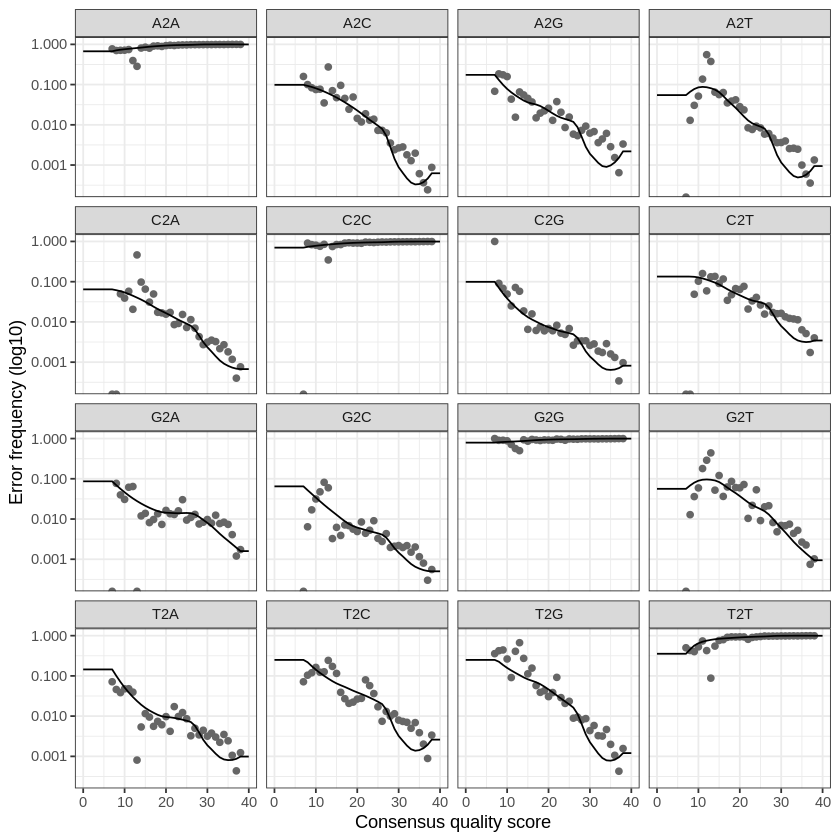

In [13]:
plotErrors(errF)

## Sequence inference

In [15]:
# # Sample inference and merger of paired-end reads
# mergers <- vector("list", length(sample.names))
# names(mergers) <- sample.names
# for(sam in sample.names) {
#   cat("Processing:", sam, "\n")
#     derepF <- derepFastq(filtFs[[sam]])
#     ddF <- dada(derepF, err=errF, multithread=ncores, pool = TRUE)
#     derepR <- derepFastq(filtRs[[sam]])
#     ddR <- dada(derepR, err=errR, multithread=ncores, pool = TRUE)
#     merger <- mergePairs(ddF, derepF, ddR, derepR)
#     mergers[[sam]] <- merger
# }
# rm(derepF); rm(derepR)

In [17]:
derepF <- derepFastq(filtFs)
    dadaFS <- dada(derepF, err=errF, multithread=ncores, pool = TRUE)

53 samples were pooled: 1575089 reads in 319447 unique sequences.


In [18]:
derepR <- derepFastq(filtRs)
    dadaRS <- dada(derepR, err=errR, multithread=ncores, pool = TRUE)

53 samples were pooled: 1575089 reads in 182403 unique sequences.


In [22]:
mergers <- mergePairs(dadaFS, derepF, dadaRS, derepR, verbose=TRUE)
# Inspect the merger data.frame from the first sample
head(mergers[[1]])

70011 paired-reads (in 1060 unique pairings) successfully merged out of 71561 (in 1733 pairings) input.
41639 paired-reads (in 877 unique pairings) successfully merged out of 42591 (in 1371 pairings) input.
51481 paired-reads (in 988 unique pairings) successfully merged out of 52614 (in 1538 pairings) input.
44496 paired-reads (in 836 unique pairings) successfully merged out of 46114 (in 1621 pairings) input.
54507 paired-reads (in 880 unique pairings) successfully merged out of 56095 (in 1686 pairings) input.
39220 paired-reads (in 918 unique pairings) successfully merged out of 40264 (in 1405 pairings) input.
30851 paired-reads (in 802 unique pairings) successfully merged out of 31545 (in 1191 pairings) input.
40801 paired-reads (in 898 unique pairings) successfully merged out of 41853 (in 1426 pairings) input.
26122 paired-reads (in 2677 unique pairings) successfully merged out of 26959 (in 3135 pairings) input.
21174 paired-reads (in 3415 unique pairings) successfully merged out of

sequence,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
TACGGAGGATCCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTTTAGTAAGTCAGTGGTGAAAGCCCATCGCTCAACGGTGGAACGGCCATTGATACTGCTGAACTTGAATTACTGGGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATGGAATACCAATTGCGAAGGCAGGTTACTACCAGTTTATTGACGCTGATGGACGAAAGCGTGGGGAGCGAACAGG,11317,1,1,43,0,0,2,TRUE
TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGG,8070,4,6,43,0,0,2,TRUE
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACACTGAGGCGCGAAAGCGTGGGGAGCAAACAGG,6295,7,14,43,0,0,2,TRUE
TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGACATGTAAGTCCGTGGTGAAATCTCCGAGCTTAACTCGGAAACTGCCATGGATACTATATGTCTTGAATGTTGTGGAGGTTAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCAATTGCGAAGGCAGCTGGCTACACAAATATTGACGCTGAGGCACGAAAGCGTGGGGATCAAACAGG,6114,3,4,43,0,0,2,TRUE
TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGAAGTCTTGAGTATGGTAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,6035,2,3,43,0,0,2,TRUE
TACAGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTGCGTAGGCGGCCAATTAAGTCAAATGTGAAATCCCCGAGCTTAACTTGGGAATTGCATTCGATACTGGTTGGCTAGAGTATGGGAGAGGATGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCCATCTGGCCTAATACTGACGCTGAGGTACGAAAGCATGGGGAGCAAACAGG,5696,9,8,43,0,0,2,TRUE


# Construct sequence table and remove chimeras

In [23]:

seqtab <- makeSequenceTable(mergers)

In [25]:
(seqtab)[1:3,1:5]

,TACGGAGGATCCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTTTAGTAAGTCAGTGGTGAAAGCCCATCGCTCAACGGTGGAACGGCCATTGATACTGCTGAACTTGAATTACTGGGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATGGAATACCAATTGCGAAGGCAGGTTACTACCAGTTTATTGACGCTGATGGACGAAAGCGTGGGGAGCGAACAGG,TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGAAGTCTTGAGTATGGTAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGACATGTAAGTCCGTGGTGAAATCTCCGAGCTTAACTCGGAAACTGCCATGGATACTATATGTCTTGAATGTTGTGGAGGTTAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCAATTGCGAAGGCAGCTGGCTACACAAATATTGACGCTGAGGCACGAAAGCGTGGGGATCAAACAGG,GACATAGGTGGCAAACATTATCCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGCATGATAAGTTGCTGGTGGGAAATCAAGGCTCAACCTTGTGGAAGCTAGCAATACTGTCAAGCTAGAGGGCAGAAGAGGTTAACGGAACTCTATGTGGAGCGGTAAAATGTGTAGATATATAGAAGAACATCAATAAAGGCGAAGGCAGTTAACTAGTCTGTCCCTGACGTTGAGGCACGAAAGCGTGGGGAGCAAAACGG,TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGG
10xBLS156_S303,11317,6035,6114,0,8070
2xBLS143_S297,8160,5595,5334,0,2607
5xBLS120_S300,13643,7319,5304,0,3266


In [26]:
outFile = file.path(OutFolder,"seqtab_wPooledDadaPipeline.rds")
saveRDS(seqtab, outFile) 

In [27]:
dim(seqtab)
# Inspect distribution of sequence lengths
table(nchar(getSequences(seqtab)))

[1]    53 21630


  191   195   196   198   199   200   202   209   210   213   214   217   218 
   11     1     1     1     1     2     2     2     1     1     1     1     1 
  220   221   222   223   224   226   227   228   229   230   231   232   236 
    5    12     2    11     2     1     2     4     1     2     2     2     2 
  239   240   241   242   243   244   246   247   248   249   250   251   252 
    2     1     1     2     1     1     2     6     5     7     8    20   191 
  253   254   255   256   257   258   259   260   261   262   263   264   265 
19529  1291    93   140    54    11     9     1     3     2     1     2     8 
  267   269   270   271   272   273   275   276   279   280   282   283   284 
    3    27     5    54    22    43     1     1     1     1     4     1     2 

## subset to proper sequence lengths

In [28]:
seqtab2 <- seqtab[,nchar(colnames(seqtab)) %in% seq(251,256)]

table(nchar(getSequences(seqtab2)))


  251   252   253   254   255   256 
   20   191 19529  1291    93   140 

## Remove chimeras

* removes all sequences that can be exactly reconstructed as a bimera of two more abundant sequences

In [29]:
seqtab.nochim <- removeBimeraDenovo(seqtab2, method="consensus", multithread=ncores, verbose=TRUE)

Identified 7374 bimeras out of 21264 input sequences.


In [50]:
dim(seqtab.nochim)

[1]    53 12083

In [30]:
outFile = file.path(OutFolder,"seqtab-seqtab_wPooledDadaPipeline.rds")

saveRDS(seqtab.nochim, outFile)

# Generate rarefaction curves

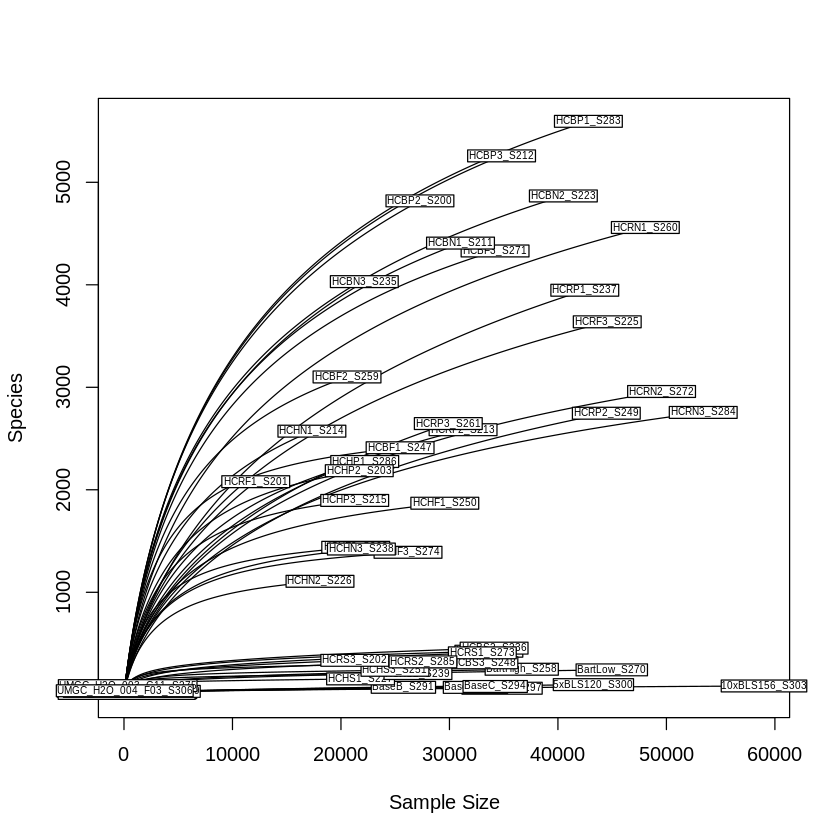

In [33]:
out = vegan::rarecurve(seqtab.nochim,step = 50, cex = 0.5)

In [38]:
rare <- lapply(out, function(x){
  b <- as.data.frame(x)
  b <- data.frame(OTU = b[,1], raw.read = rownames(b))
  b$raw.read <- as.numeric(gsub("N", "",  b$raw.read))
  return(b)
})

In [42]:
names(rare) <- rownames(seqtab.nochim)

In [45]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘ggplot2’ was built under R version 3.6.1”Warning message:
“package ‘tibble’ was built under R version 3.6.1”Warning message:
“package ‘stringr’ was built under R version 3.6.1”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [46]:
rare <- map_dfr(rare, function(x){
  z <- data.frame(x)
  return(z)
}, .id = "sample")
head(rare)

sample,OTU,raw.read
10xBLS156_S303,1.00000,1
10xBLS156_S303,12.76796,51
10xBLS156_S303,15.14727,101
10xBLS156_S303,16.46723,151
10xBLS156_S303,17.38678,201
10xBLS156_S303,18.11059,251


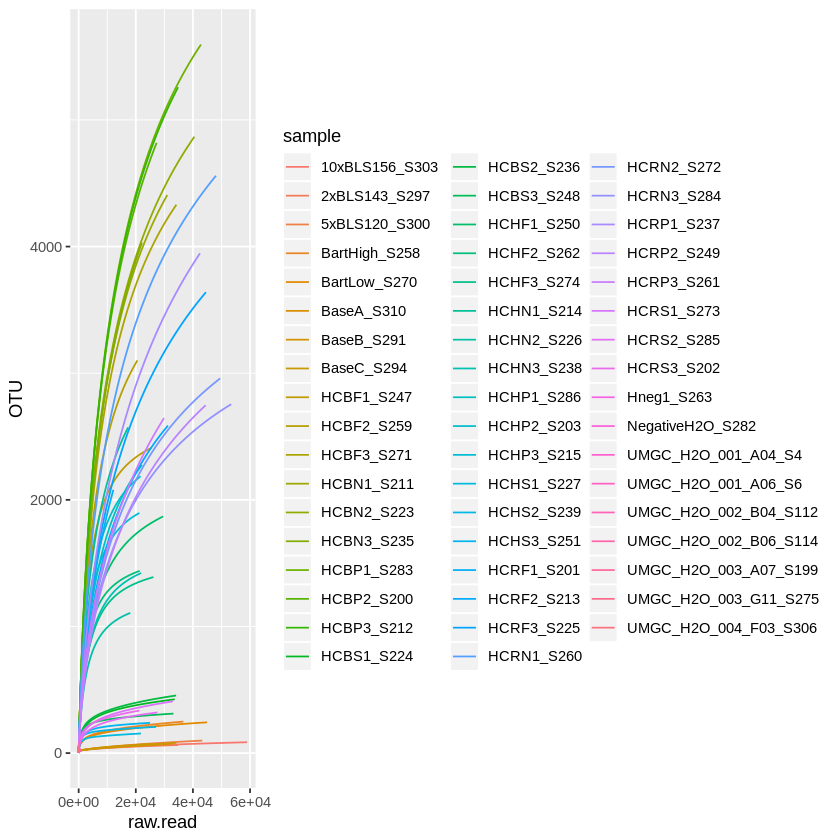

In [47]:
ggplot(data = rare)+
  geom_line(aes(x = raw.read, y = OTU, color = sample))+
  scale_x_continuous(labels =  scales::scientific_format())

In [50]:
df = read.delim(SamTab, sep = '\t', header = TRUE)
head(df)

SampleID,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
HCBN1_S211,HCBN1,1,N1,Gv,Dryden,CS,HN,NA,81,1,6.08
HCBN2_S223,HCBN2,1,N2,Gv,Dryden,CS,HN,NA,81,2,7.58
HCBN3_S235,HCBN3,1,N3,Gv,Dryden,CS,HN,NA,81,3,7.05
HCBF1_S247,HCBF1,1,F1,Gv,Florence,CS,HN,NA,81,1,2.32
HCBF2_S259,HCBF2,1,F2,Gv,Florence,CS,HN,NA,81,2,2.08
HCBF3_S271,HCBF3,1,F3,Gv,Florence,CS,HN,NA,81,3,1.89


In [51]:
rare = left_join(rare, df, by = c("sample"="SampleID"))

In [52]:
head(rare)

sample,OTU,raw.read,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
10xBLS156_S303,1.00000,1,10xBLS156,1,,,,MK,,NA,NA,NA,NA
10xBLS156_S303,12.76796,51,10xBLS156,1,,,,MK,,NA,NA,NA,NA
10xBLS156_S303,15.14727,101,10xBLS156,1,,,,MK,,NA,NA,NA,NA
10xBLS156_S303,16.46723,151,10xBLS156,1,,,,MK,,NA,NA,NA,NA
10xBLS156_S303,17.38678,201,10xBLS156,1,,,,MK,,NA,NA,NA,NA
10xBLS156_S303,18.11059,251,10xBLS156,1,,,,MK,,NA,NA,NA,NA


In [60]:
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

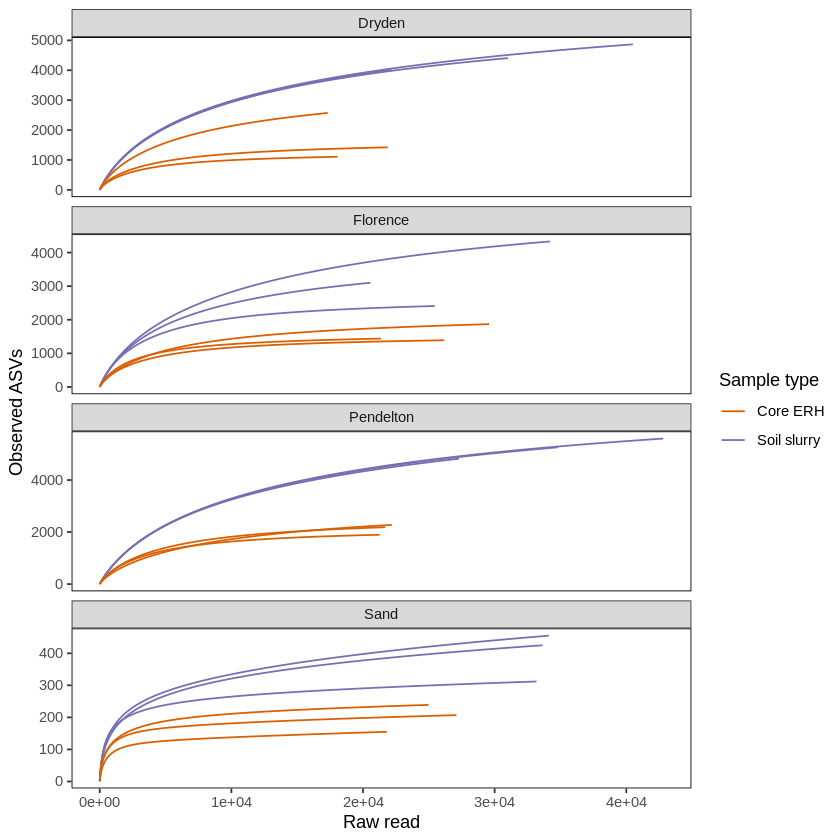

In [68]:
cs = c('#D95F02', '#7570B3')
plot = rare %>%
filter(SampleType %in% c("CH", "CS")) %>%
ggplot()+
  geom_line(aes(x = raw.read, y = OTU, group = sample, color = SampleType))+
  scale_x_continuous(labels =  scales::scientific_format())+
  scale_color_manual(values = cs, labels = c("Core ERH", "Soil slurry"))+
  facet_wrap(~Soil, ncol = 1, scales = 'free_y')+
  theme_pub()+
  xlab("Raw read")+
  ylab("Observed ASVs")+
  labs(color = "Sample type")

plot

In [71]:
pdf(file = '~/Hyphosphere/data/3Exp/figures/final/RarefactionCurves.pdf', width = 5, height = 7, useDingbats = FALSE)
plot
dev.off()

png 
  2

# Checkpoint read seqtab.nochim

In [57]:
CheckPoint = file.path(OutFolder,"seqtab-nochim.rds")

seqtab.nochim = readRDS(CheckPoint)

In [61]:
paste("Fraction of reads attributed to chimeras:", sum(seqtab.nochim)/sum(seqtab))

[1] "Fraction of reads attributed to chimeras: 0.935940282961549"

# Track reads through the pipeline

In [63]:
 #Track
  getN <- function(x) sum(getUniques(x))
  track <- cbind(out, rowSums(seqtab),rowSums(seqtab.nochim))
  # If processing a single sample, remove the sapply calls: e.g. replace sapply(dadaFs, getN) with getN(dadaFs)
  dim(track)
  colnames(track) <- c("input", "filtered", "seqtable", "nonchim")
  rownames(track) <- sample.names
  head(track)

[1] 53  4

,input,filtered,seqtable,nonchim
10xBLS156_S303,76535,71931,69469,59843
2xBLS143_S297,46036,42761,41067,35803
5xBLS120_S300,58139,52793,50890,44074
BartHigh_S258,50441,46587,44278,37880
BartLow_S270,59500,56642,54238,45142
BaseA_S310,43371,40476,38447,33584


In [65]:
outFile = file.path(OutFolder,'Tracking.txt')
write.table(track, file = outFile, sep = "\t")

# Assign taxonomy

* hold off here and wait for processing and merging of other experiments so that one master ASV and taxa table can be created